## Summary

This tutorial uses napari 0.4.11.<br>
Inspired by tutorials > single cell tracking with napari.

Dataset :<br>
[Chinese Hamster Ovarian (CHO) nuclei overexpressing GFP-PCNA from cell tracking challenge](http://data.celltrackingchallenge.net/training-datasets/Fluo-N3DH-CHO.zip).<br> 
3D time-lapse (xyzct = 512x443x5x1x92), ~100 MB<br>
Voxel size (microns, xyz): 0.202 x 0.202 x 1.0<br>
Time step (min): 9.5

Analysis goals:<br> 
(1) Measure cell movement over time.<br>
(2) Measure cell area change over time.<br>

Tutorial goals:<br>
(1) Use napari + Python libraries to perform common image analysis from end to end.<br>
(2) Note napari viewer GUI/API function availability at varioius steps.  

Steps:
- Load timelapse image (celltracking)
- Get image dimension and display with correct axes
- Smooth the image using Gaussian filter
<br><br>
- Object detection: points
- Tracking points
- Filter tracks by track length
- Calculate instant speed
<br><br>
- Object detection: labels
- Labels to Points for tracking
- Save track results

<font color=red> RED: links to add<br> </font>
<font color=blue> BLUE: GUI availability in viewer </font>

In [245]:
import napari
from napari.utils import nbscreenshot
viewer = napari.Viewer()

## Load timelapse image

This tutorial only uses files in Fluo-N3DH-CHO > 01 folder.<br>
92 tif files are in the folder (t000.tif, ..., t091.tif), each represents a 3D image acquired at a given time point.

<font color=blue> 
    GUI option 1: File > Open Files as Stack...> select all tif files in the folder.<br>
    GUI option 2: File > Open Folder > select 01 folder.<br>
</font>
<font color=red>link: supported file format and plugins</font>

In [246]:
import os
import numpy as np
from skimage.io import imread

#modify the file path to match file location
img_path = '/Users/cchiu/Desktop/images/Fluo-N3DH-CHO/01/'

#get the total number of files in the folder
num_files = len(os.listdir(img_path))
print('number of tif files: ',num_files)

def load_timelapse(idx: int):
    filename = os.path.join(img_path, f't{idx:0>3}.tif')
    return imread(filename)

#load all tif files as single array
stack = np.asarray([load_timelapse(i) for i in range(num_files)])
print('stack size: ',stack.shape)

number of tif files:  92


tifffile.py (9833): coroutine 'get_msg' was never awaited


stack size:  (92, 5, 443, 512)


## Get image dimension and display with correct axes
The original shape is (92, 5, 443, 512), corresponding to axes order TZYX.<br>
napari takes the axes order TZYX with C represented as separate image layers, so no additional steps are needed.<br> 
If the image stack order is not correct, use np.transpose to get the dimensions in the right order, then split each channel as one image layer for easier display/analysis.<br>

For the remaining tutorial, only the first 10 time points will be used for faster calculation.<br>

[<font color=blue>issue 2917</font>](https://github.com/napari/napari/issues/2917),
[<font color=blue>issue 906</font>](https://github.com/napari/napari/issues/906)

<font color=blue>
    A 2D timelapse and a 3D image cannot be differentiated due to the lack of axis names. This can make downstream analysis ambiguous - and error prone - see the segmentation part. <br>     
    Changing axes is challenging to do in GUI<br>
    No simple way to crop/select certain dimensions in GUI.<br>
</font>


In [247]:
#load only the first 10 time points and only uses the first z slice
small_stack = stack[0:10,0,:,:]

viewer = napari.view_image(small_stack, name="cells")
print(small_stack.shape)

(10, 443, 512)
2021-10-07 16:42:11,525 [ERROR] Exception in callback BaseAsyncIOLoop._handle_events(332, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(332, 1)>
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/cchiu/PycharmProjects/napari_new/venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/Users/cchiu/PycharmProjects/napari_new/venv/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "/Users/cchiu/PycharmProjects/napari_new/venv/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 477, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/cchiu/PycharmProjects/napari_new/venv/lib/python3.8/site-packages/zmq/eventloop/z

## Smooth the image using Gaussian filter

Smoothed image (and other pre-processing steps) can simplify segmentation/object detection by removing unwanted signal variations.<br>

Use skimage.filters.gaussian to perform Gaussian smoothing. <br>
Because we only want to smooth along xy dimension, t sigma is set to 0.

In [248]:
import skimage
smoothed = skimage.filters.gaussian(small_stack, sigma=[0,8,8])
viewer.add_image(smoothed, name='smoothed')

__init__.py (551): coroutine 'get_msg' was never awaited


<Image layer 'smoothed' at 0x1d850f8e0>

## Object detection: Points

Some analyses only require tracking the centroid of the objects, i.e. speed, directionality, etc.<br>

<font color=blue>napari-stracking plugin > S Detector Dog/Doh/Log</font><br>
<font color=red>Points layer tutorial</font>

In [249]:
#find points per time point, and store the result as [time index, y coordinate, x coordinate]
def peaks(time_point):
    blobs = skimage.feature.blob_log(smoothed[time_point,:,:],min_sigma=5,threshold=0.08,overlap=0.4)
    points = np.empty(3)
    for blob in blobs:
        point = [time_point,blob[0],blob[1]]
        points = np.vstack([points,point])
    return points[1:]

#detect points for all time points
points_all = np.empty(3)
for t in range(viewer.layers['cells'].data.shape[0]):
    points = peaks(t)
    points_all = np.vstack([points_all,points])

#add points as points layer
viewer.add_points(points_all[1:], size=10, name='cell_points')

#a better way than adding np.empty?

<Points layer 'cell_points' at 0x1d6ccd1f0>

detections shape= (96, 3)
num frames= 10
cost= 80.0
self.cost.max_cost= 900.0
cost= 79460.0
self.cost.max_cost= 900.0
cost= 20114.0
self.cost.max_cost= 900.0
cost= 93685.0
self.cost.max_cost= 900.0
cost= 183668.0
self.cost.max_cost= 900.0
cost= 32968.0
self.cost.max_cost= 900.0
cost= 121645.0
self.cost.max_cost= 900.0
cost= 271729.0
self.cost.max_cost= 900.0
cost= 241985.0
self.cost.max_cost= 900.0
cost= 78962.0
self.cost.max_cost= 900.0
cost= 2.0
self.cost.max_cost= 900.0
cost= 19400.0
self.cost.max_cost= 900.0
cost= 45721.0
self.cost.max_cost= 900.0
cost= 35570.0
self.cost.max_cost= 900.0
cost= 48250.0
self.cost.max_cost= 900.0
cost= 46657.0
self.cost.max_cost= 900.0
cost= 73933.0
self.cost.max_cost= 900.0
cost= 54485.0
self.cost.max_cost= 900.0
cost= 19409.0
self.cost.max_cost= 900.0
cost= 20449.0
self.cost.max_cost= 900.0
cost= 17.0
self.cost.max_cost= 900.0
cost= 47986.0
self.cost.max_cost= 900.0
cost= 89081.0
self.cost.max_cost= 900.0
cost= 22469.0
self.cost.max_cost= 900.0
cost=

cost= 201266.0
self.cost.max_cost= 900.0
cost= 54760.0
self.cost.max_cost= 900.0
cost= 26658.0
self.cost.max_cost= 900.0
cost= 22658.0
self.cost.max_cost= 900.0
cost= 6137.0
self.cost.max_cost= 900.0
cost= 109613.0
self.cost.max_cost= 900.0
cost= 2420.0
self.cost.max_cost= 900.0
cost= 113714.0
self.cost.max_cost= 900.0
cost= 128.0
self.cost.max_cost= 900.0
cost= 146557.0
self.cost.max_cost= 900.0
cost= 172405.0
self.cost.max_cost= 900.0
cost= 173729.0
self.cost.max_cost= 900.0
cost= 57461.0
self.cost.max_cost= 900.0
cost= 36397.0
self.cost.max_cost= 900.0
cost= 152002.0
self.cost.max_cost= 900.0
cost= 36100.0
self.cost.max_cost= 900.0
cost= 142237.0
self.cost.max_cost= 900.0
cost= 29.0
self.cost.max_cost= 900.0
cost= 119925.0
self.cost.max_cost= 900.0
cost= 4082.0
self.cost.max_cost= 900.0
cost= 6746.0
self.cost.max_cost= 900.0
cost= 236905.0
self.cost.max_cost= 900.0
cost= 94977.0
self.cost.max_cost= 900.0
cost= 61925.0
self.cost.max_cost= 900.0
cost= 203876.0
self.cost.max_cost= 900.

self.cost.max_cost= 900.0
cost= 13.0
self.cost.max_cost= 900.0
cost= 28953.0
self.cost.max_cost= 900.0
cost= 48200.0
self.cost.max_cost= 900.0
cost= 41680.0
self.cost.max_cost= 900.0
cost= 19133.0
self.cost.max_cost= 900.0
cost= 8693.0
self.cost.max_cost= 900.0
cost= 66052.0
self.cost.max_cost= 900.0
cost= 46393.0
self.cost.max_cost= 900.0
cost= 35113.0
self.cost.max_cost= 900.0
cost= 70933.0
self.cost.max_cost= 900.0
cost= 22997.0
self.cost.max_cost= 900.0
cost= 53545.0
self.cost.max_cost= 900.0
cost= 139693.0
self.cost.max_cost= 900.0
cost= 116.0
self.cost.max_cost= 900.0
cost= 131060.0
self.cost.max_cost= 900.0
cost= 113653.0
self.cost.max_cost= 900.0
cost= 46325.0
self.cost.max_cost= 900.0
cost= 61416.0
self.cost.max_cost= 900.0
cost= 36945.0
self.cost.max_cost= 900.0
cost= 172253.0
self.cost.max_cost= 900.0
cost= 81745.0
self.cost.max_cost= 900.0
cost= 49465.0
self.cost.max_cost= 900.0
cost= 28397.0
self.cost.max_cost= 900.0
cost= 1.0
self.cost.max_cost= 900.0
cost= 135220.0
self.

## Tracking points

Track layer saves array (track_id, T, Z, Y, X).<br>
Directly use plugin for track detection for simplicity.<br>

<font color=blue>napari-stracking plugin > S Linker Shortest Path</font><br>
<font color=red>tracks layer tutorial</font>

In [ ]:
#Use napari-stracking plugin > S Linker Shortest Path for tracking
#Detections layer = cell_points
#Max distance = 30
#Gap = 1

#print(viewer.layers[-1].data)

## Filter tracks by track length

Two main types of track related statistics:<br>
(1) Whole track statistics (track_stat) - track duration, avg. speed, etc.<br>
(2) Per time point statistics (point_stat) - instant speed, MSD, etc.<br>

To avoid redundancy, create two separate dataframes to store the above, with shared column 'track_ID'.<br>
This approach however requires update on both dataframes when filtering/updating one of them.<br>

Additional challenge: if we want to also update points layer and only keeps the points that only reflect the filtered result, it becomes even messier...<br>
Another common scenario: After tracking points, user may want to adjust points, and the change also needs to be propagated to track layer and the corresponding stats.<br>

<font color=blue> No known GUI/plugins </font>

In [250]:
import pandas as pd

#create point_stat from tracks layer
point_stat = pd.DataFrame(viewer.layers[-1].data, columns = ['track_ID','time','coor_y','coor_x'])
point_stat['track_ID'] = point_stat['track_ID'].astype(int)

#create track_stat with unique track_ID, and add track_length stats
track_length = point_stat['track_ID'].value_counts()
track_stat = pd.DataFrame(track_length)
track_stat = track_stat.reset_index()
track_stat.columns = ['track_ID', 'track_length'] 

#print('track_stat:')
#display(track_stat)

#only keeps tracks with track_length > 6
#filter both track_stat and point_stat
min_length = 6

f_track_stat = track_stat[track_stat['track_length'] > min_length].dropna()
print('f_track_stat:')
display(f_track_stat)

f_point_stat = point_stat[point_stat['track_ID'].isin(f_track_stat.track_ID.tolist())]
display(f_point_stat)

f_track_stat:


,track_ID,track_length
0,0,10
1,1,10
2,2,10
3,3,10
4,4,10
5,5,8
6,8,7


,track_ID,time,coor_y,coor_x
0,0,0.0,243.0,122.0
1,0,1.0,242.0,121.0
2,0,2.0,247.0,122.0
3,0,3.0,251.0,130.0
4,0,4.0,253.0,127.0
...,...,...,...,...
72,8,4.0,442.0,253.0
73,8,5.0,417.0,250.0
74,8,6.0,442.0,254.0
75,8,7.0,426.0,252.0


## Calculate instant speed

In [251]:
import math
def speed(y1,y2,x1,x2):
    s = math.sqrt((y2-y1)**2+(x2-x1)**2)
    if np.isnan(s):
        return 0
    else:
        return s

#add new columns coor_yp and coor_xp for the coordinates from the previous time point. 
#For time point 0, coor_yp = coor_y, coor_xp = coor_x

f_point_stat['coor_yp']=f_point_stat.shift(periods=1)['coor_y']
f_point_stat['coor_xp']=f_point_stat.shift(periods=1)['coor_x']

#calculate instant speed for all time points
for index, row in f_point_stat.iterrows():
    new_speed = speed(row['coor_y'],row['coor_yp'],row['coor_x'],row['coor_xp'])
    f_point_stat.at[index, 'speed'] = new_speed

display(f_point_stat)

1964279515.py (12): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
1964279515.py (13): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
indexing.py (1684): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
indexing.py (1817): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,track_ID,time,coor_y,coor_x,coor_yp,coor_xp,speed
0,0,0.0,243.0,122.0,NaN,NaN,0.000000
1,0,1.0,242.0,121.0,243.0,122.0,1.414214
2,0,2.0,247.0,122.0,242.0,121.0,5.099020
3,0,3.0,251.0,130.0,247.0,122.0,8.944272
4,0,4.0,253.0,127.0,251.0,130.0,3.605551
...,...,...,...,...,...,...,...
72,8,4.0,442.0,253.0,442.0,253.0,0.000000
73,8,5.0,417.0,250.0,442.0,253.0,25.179357
74,8,6.0,442.0,254.0,417.0,250.0,25.317978
75,8,7.0,426.0,252.0,442.0,254.0,16.124515


## Object detection: Labels

Some analyses require capturing the overall volume of objects, i.e. morphology change, intensity fluctuation, etc.<br>

Use simple intensity threshold-based segmentation on smoothed image.<br> 

WARNING: Convert to label needs to be applied on a per time point basis, otherwise objects overlapping in time will be assigned the same label index (i.e. being treated as 3D image). This axis ambiguity can contribute to segmentation plugins not working properly. 

<Image layer 'cutoff cell' at 0x1d8898610>

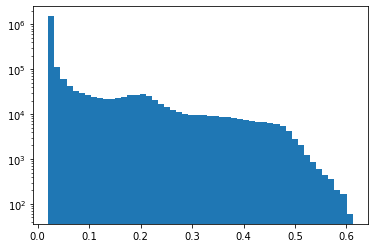

In [252]:
#Plot intensity distribution
from matplotlib.pyplot import hist
_ = hist(smoothed.flatten(),bins=50,log=True)

#binarize the image using intensity = 0.1
threshold = 0.1
cutoff_cell = smoothed > threshold
viewer.add_image(cutoff_cell, name='cutoff cell')

In [253]:
import scipy
#create connectivity structure so that objects are not considered connected along time dimension.
s = scipy.ndimage.morphology.generate_binary_structure(3,1)
s[0] = False
s[2] = False

#turn binary image into labels layer
seg_cell,num_objs = scipy.ndimage.label(cutoff_cell, structure=s)
viewer.add_labels(seg_cell, name='cell seg')

<Labels layer 'cell seg' at 0x1d87673a0>

## Labels to Points for tracking

Same considerations as for Points, multiple dataframes may be needed to hold the information.<br>
Once Labels coordinates are converted into points, the same process of tracking can be applied.

<font color=blue> Would be nice to have tracking directly on labels and bypass adding additional layers :)</font>

In [254]:
#extract object coordinates for tracking
from skimage.measure import regionprops_table

p = ['label', 'centroid','area'] #additional properties can be added here
obj_stat = pd.DataFrame(regionprops_table(seg_cell,intensity_image=small_stack,properties=p))
obj_stat = obj_stat.rename(columns={"centroid-0": "time", "centroid-1": "coor_y","centroid-2": "coor_x"})
display(obj_stat)
label_point = obj_stat[['time','coor_y','coor_x']].to_numpy()
viewer.add_points(label_point, size=10, name='label_points')

,label,time,coor_y,coor_x,area
0,1,0.0,19.603250,16.145565,1477
1,2,0.0,68.985004,57.620702,5468
2,3,0.0,96.941840,229.615951,8150
3,4,0.0,205.176983,102.039869,11939
4,5,0.0,298.625811,253.122566,4006
...,...,...,...,...,...
80,81,9.0,228.833058,204.828512,4840
81,82,9.0,299.656621,399.198470,6404
82,83,9.0,403.424768,250.540557,4845
83,84,9.0,412.819382,158.950012,4241


<Points layer 'label_points' at 0x1d81134f0>

## Save track results

Since tracking analyses require information from several layer sources, save all layers may be necessary.

<font color=blue> File > Save All Layers... </font> 